###**Abstract**:
The main goal of this project is to make you feel familiar with Supervised Learning Algorithms like Regression and Gradient Boosting algorithms along with practicing more Exploratory Data Analysis techniques and developing your ML intuition.


###**Description**:
The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.
The solution will enhance the company’s revenues and reduce the losses caused by such fraudulent activities.


###**Data Problem**:
Building a model that will help classify which customer is likely to commit fraud and by that saving the company from making losses.


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, validation_curve,learning_curve,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2,f_classif, SelectKBest
from imblearn.over_sampling import ADASYN, SMOTEN
from xgboost import XGBClassifier as xgb
import sklearn.metrics as mt
from itertools import cycle

In [2]:
import os
import zipfile
##extract the train dataset
local_zip_train = '/content/drive/MyDrive/project/train.zip'

zip_ref = zipfile.ZipFile(local_zip_train, 'r')

zip_ref.extractall('/content/steg/train')
zip_ref.close()

#extract the test dataset
local_zip_test = '/content/drive/MyDrive/project/test.zip'

zip_ref = zipfile.ZipFile(local_zip_test, 'r')

zip_ref.extractall('/content/steg/test')
zip_ref.close()

In [3]:
##data extraction
base_dir = '/content/steg'

#train directory with client and invoice dataset
train_dir = os.path.join(base_dir, 'train')

#test directory with client and invoice dataset
test_dir = os.path.join(base_dir, 'test')



In [4]:
## read the dataset we will start by the client_train dataset
client_train=pd.read_csv(train_dir+'/client_train.csv')
client_test=pd.read_csv(test_dir+'/client_test.csv')
invoice_train=pd.read_csv(train_dir+'/invoice_train.csv')
invoice_test=pd.read_csv(test_dir+'/invoice_test.csv')
client_train.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [5]:
client_train

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0
...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,26/07/2004,0.0
135489,63,train_Client_99996,11,311,25/10/2012,0.0
135490,63,train_Client_99997,11,311,22/11/2011,0.0
135491,60,train_Client_99998,11,101,22/12/1993,0.0


In [6]:
# columns info 
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [7]:
#check the Null val
client_train.isnull().any()

disrict          False
client_id        False
client_catg      False
region           False
creation_date    False
target           False
dtype: bool

we observe that our dataset does not have any null values



In [8]:
from pandas.core.base import duplicated
# check the duplicate
client_train.duplicated().sum()

0

our dataset does not have any duplicate rows

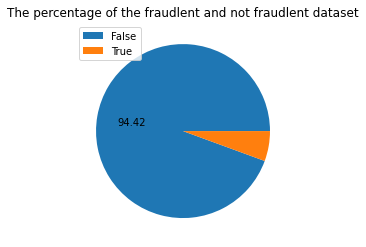

In [9]:

def autopct(pct): # only show the label when it's > 10%
    return ('%.2f' % pct) if pct > 10 else ''

ax=client_train['target'].value_counts().plot(kind='pie', figsize=(8,4), autopct=autopct, labels=None,
                                              title='The percentage of the fraudlent and not fraudlent dataset')
ax.axes.get_yaxis().set_visible(False)
plt.legend(loc=2, labels=("False",'True'))


our data is not balanced that we have 94.4% not fraud and just 5.6% that was really a fraud

In [10]:
#describe the data when it was fraud
client_train[client_train.target==1].describe().T

,count,mean,std,min,25%,50%,75%,max
disrict,7566.0,64.211208,3.437296,60.0,62.0,63.0,69.0,69.0
client_catg,7566.0,12.508327,7.588900,11.0,11.0,11.0,11.0,51.0
region,7566.0,210.847608,104.732726,101.0,103.0,301.0,309.0,399.0
target,7566.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [11]:
#describe the data when it was not fraud
client_train[client_train.target==0].describe().T

,count,mean,std,min,25%,50%,75%,max
disrict,127927.0,63.469823,3.344862,60.0,62.0,62.0,63.0,69.0
client_catg,127927.0,11.453610,4.154425,11.0,11.0,11.0,11.0,51.0
region,127927.0,205.882558,104.169675,101.0,101.0,107.0,307.0,399.0
target,127927.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'was fraud')

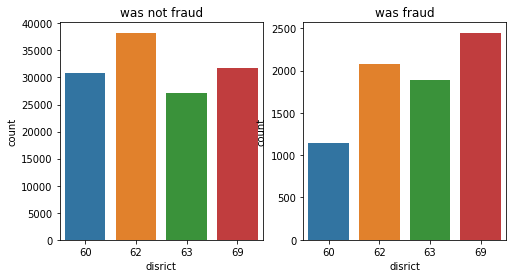

In [12]:
#visualize the client disrict distribution between the cases of the fraud and not
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.countplot(x="disrict",data=client_train[client_train.target==0])
plt.title('was not fraud')
plt.subplot(1,2,2)
sns.countplot(x="disrict",data=client_train[client_train.target==1])
plt.title('was fraud')

we observe that the disrict distribution between the client that who did a fraudlent activity and who did not we could say that it is a random distribution except a small reduce of the persentage of the clients from the disrict 60 in the fraud cases.

Text(0.5, 1.0, 'was fraud')

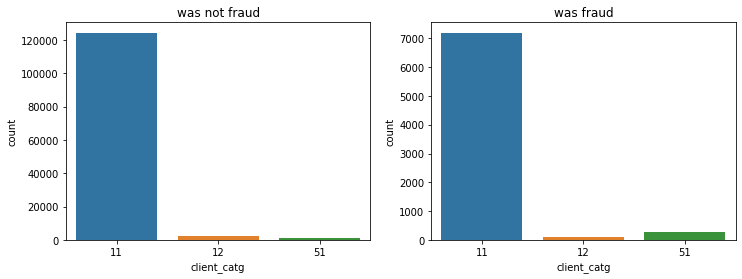

In [13]:
#visualize the categ distribution 
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x="client_catg",data=client_train[client_train.target==0])
plt.title('was not fraud')
plt.subplot(1,2,2)
sns.countplot(x="client_catg",data=client_train[client_train.target==1])
plt.title('was fraud')

We find that the big majority of the client belong to the category "11" with a small raise of the percentage of the client from category '51' in the fraud cases. 

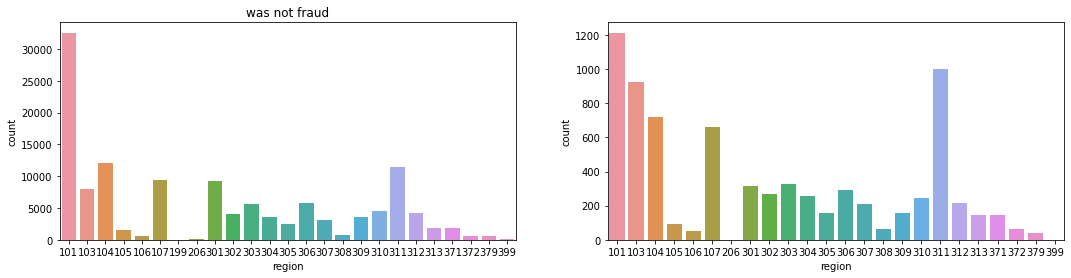

In [14]:
plt.figure(figsize=(18,4))
plt.title('region distribution')
plt.subplot(1,2,1)
sns.countplot(x="region",data=client_train[client_train.target==0])
plt.title('was not fraud')
plt.subplot(1,2,2)
sns.countplot(x="region",data=client_train[client_train.target==1])


In [15]:
client_train.region.value_counts()

101    33770
104    12865
311    12406
107     9998
301     9544
103     8964
306     6044
303     5982
310     4851
312     4379
302     4311
304     3828
309     3669
307     3376
305     2716
313     2076
371     2065
105     1645
308      841
106      706
372      644
379      583
399      175
206       53
199        2
Name: region, dtype: int64

There are some small diffrences between the region distribution in the 2 cases:
Remarquable raise in the percentage of clients from regions: 103, 104, 107 & 311 in the fraud cases.

In [16]:
#convert the client category and disrict to a object type
client_train['client_catg'] = client_train['client_catg'].astype('object')
client_train['disrict'] = client_train['disrict'].astype('object')

In [17]:
#dealing with creation date
client_train['creation_date']=pd.to_datetime(client_train['creation_date'],format='%d/%m/%Y')
client_train['creation_day']=client_train.creation_date.dt.day
client_train['creation_month']=client_train.creation_date.dt.month
client_train['creation_year']=client_train.creation_date.dt.year
client_train

,disrict,client_id,client_catg,region,creation_date,target,creation_day,creation_month,creation_year
0,60,train_Client_0,11,101,1994-12-31,0.0,31,12,1994
1,69,train_Client_1,11,107,2002-05-29,0.0,29,5,2002
2,62,train_Client_10,11,301,1986-03-13,0.0,13,3,1986
3,69,train_Client_100,11,105,1996-07-11,0.0,11,7,1996
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,10,2014
...,...,...,...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,2004-07-26,0.0,26,7,2004
135489,63,train_Client_99996,11,311,2012-10-25,0.0,25,10,2012
135490,63,train_Client_99997,11,311,2011-11-22,0.0,22,11,2011
135491,60,train_Client_99998,11,101,1993-12-22,0.0,22,12,1993


Text(0.5, 1.0, 'was fraud')

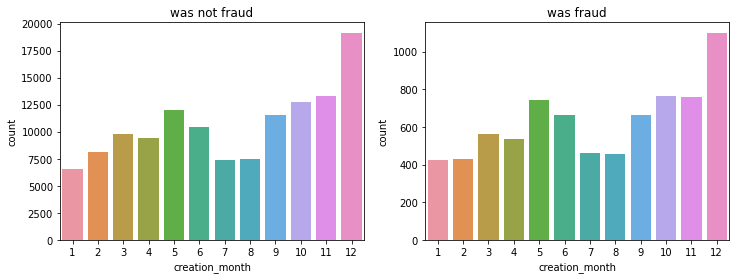

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x="creation_month",data=client_train[client_train.target==0])
plt.title('was not fraud')
plt.subplot(1,2,2)
sns.countplot(x="creation_month",data=client_train[client_train.target==1])
plt.title('was fraud')

<Figure size 576x288 with 0 Axes>

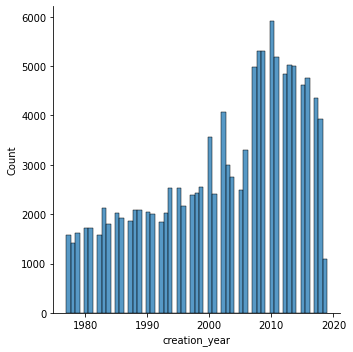

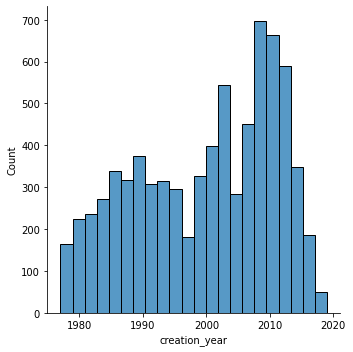

In [19]:
plt.figure(figsize=(8,4))
sns.displot(data=client_train[client_train.target==0],x="creation_year")
sns.displot(data=client_train[client_train.target==1],x="creation_year")

we can conclude that the creation date has no meaning in what if the client was fraud or not


###One-Hot Encoding

In [20]:
#we will apply the one-hot encoding for the client disrict and category
categ_dummies=pd.get_dummies(client_train['client_catg'])
res1=pd.concat([client_train,categ_dummies],axis=1)
res1=res1.drop(['client_catg',12],axis=1)


In [21]:
disrict_dummies=pd.get_dummies(res1['disrict'])
res2=pd.concat([res1,disrict_dummies],axis=1)
res2=res2.drop(['disrict',63],axis=1)


In [22]:
res2.columns

Index([     'client_id',         'region',  'creation_date',         'target',
         'creation_day', 'creation_month',  'creation_year',               11,
                     51,               60,               62,               69],
      dtype='object')

###Data Cleaning

In [23]:
#here we will update our original dataset and remove the unnecessary columns
client_train_updated=res2.drop(['creation_date','creation_year','creation_day','creation_month'],axis=1)
client_train_updated.rename(columns={11:'categ_11',51:'categ_51',60:'disrict_60',62:'disrict_62',69:'disrict_69'},inplace=True)


In [24]:
client_train_updated

,client_id,region,target,categ_11,categ_51,disrict_60,disrict_62,disrict_69
0,train_Client_0,101,0.0,1,0,1,0,0
1,train_Client_1,107,0.0,1,0,0,0,1
2,train_Client_10,301,0.0,1,0,0,1,0
3,train_Client_100,105,0.0,1,0,0,0,1
4,train_Client_1000,303,0.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
135488,train_Client_99995,304,0.0,1,0,0,1,0
135489,train_Client_99996,311,0.0,1,0,0,0,0
135490,train_Client_99997,311,0.0,1,0,0,0,0
135491,train_Client_99998,101,0.0,1,0,1,0,0


##Dealling with the invoice training data

In [25]:
#visualize the dataset
invoice_train

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


In [26]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [27]:
#convert the client category and disrict to a object type
invoice_train['counter_number'] = invoice_train['counter_number'].astype('object')
invoice_train['counter_statue'] = invoice_train['counter_statue'].astype('object')
invoice_train['tarif_type'] = invoice_train['tarif_type'].astype('object')
invoice_train['counter_code'] = invoice_train['counter_code'].astype('object')
invoice_train['counter_coefficient'] = invoice_train['counter_coefficient'].astype('object')
invoice_train['months_number'] = invoice_train['months_number'].astype('object')


Text(0.5, 1.0, 'tarif_type')

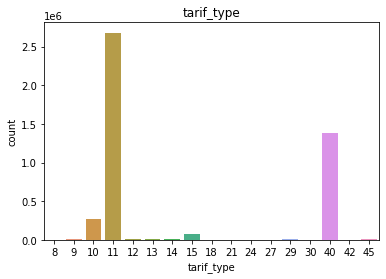

In [28]:

sns.countplot(x="tarif_type",data=invoice_train)
plt.title('tarif_type')

Text(0.5, 1.0, 'counter_type')

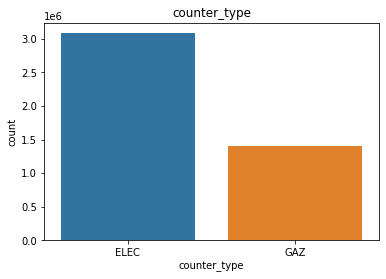

In [29]:
sns.countplot(x="counter_type",data=invoice_train)
plt.title('counter_type')

Text(0.5, 1.0, 'counter_statue')

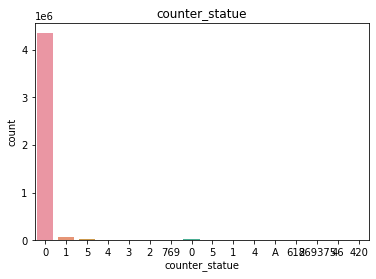

In [30]:
sns.countplot(x="counter_statue",data=invoice_train)
plt.title('counter_statue')

Text(0.5, 1.0, 'counter_coefficient')

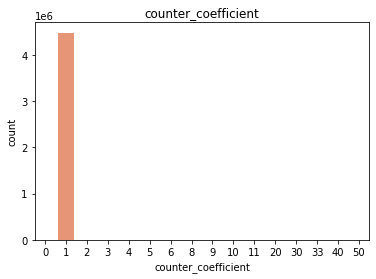

In [31]:
sns.countplot(x="counter_coefficient",data=invoice_train)
plt.title('counter_coefficient')

###Data Cleaning

In [32]:
#checking the null values
invoice_train.isna().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [33]:
#check the duplicate values
invoice_train[invoice_train.duplicated()].count()

client_id               11
invoice_date            11
tarif_type              11
counter_number          11
counter_statue          11
counter_code            11
reading_remarque        11
counter_coefficient     11
consommation_level_1    11
consommation_level_2    11
consommation_level_3    11
consommation_level_4    11
old_index               11
new_index               11
months_number           11
counter_type            11
dtype: int64

we have 11 duplicated values we can just remove them

In [34]:
#drop the duplicated
invoice_train.drop_duplicates(inplace=True)

In [35]:
## describe the value count for the objects variables
invoice_train.counter_statue.value_counts()


0         4346960
1           73496
0           32048
5           20484
4            2706
1             540
3             258
5             144
2              32
4              23
46             14
A              13
618            12
769             6
269375          1
420             1
Name: counter_statue, dtype: int64

Here we observe that there are some characters values and some extrem values '>5' that we should clean it

In [36]:
#remove the A & the extrem values
invoice_train1=invoice_train[(invoice_train['counter_statue']!='A')&(invoice_train['counter_statue']!=46)&(invoice_train['counter_statue']!=618)&
(invoice_train['counter_statue']!=769)
&(invoice_train['counter_statue']!=269375)
&(invoice_train['counter_statue']!=420)]

In [ ]:
#convert the numbers from character to int
invoice_train1[invoice_train1.counter_statue=="0"]=0
invoice_train1[invoice_train1.counter_statue=="1"]=1
invoice_train1[invoice_train1.counter_statue=="2"]=2
invoice_train1[invoice_train1.counter_statue=="3"]=3
invoice_train1[invoice_train1.counter_statue=="4"]=4
invoice_train1[invoice_train1.counter_statue=="5"]=5

In [38]:
## describe the value count for the objects counter_statue
invoice_train1.counter_statue.value_counts()

0    4379008
1      74036
5      20628
4       2729
3        258
2         32
Name: counter_statue, dtype: int64

In [40]:
## describe the value count for the objects counter_coefficient
invoice_train1.counter_coefficient.value_counts()

1     4442866
0       32091
2         886
3         321
40        197
5         145
30        137
4          35
10          6
20          3
50          2
33          1
11          1
Name: counter_coefficient, dtype: int64

In [41]:
## describe the value count for the objects reading_remarque
invoice_train1.reading_remarque.value_counts()

6    2214499
9    1406875
8     821912
0      32048
7        650
1        540
5        144
4         23
Name: reading_remarque, dtype: int64

In [42]:
invoice_train1.describe().T


,count,mean,std,min,25%,50%,75%,max
reading_remarque,4476691.0,7.266543,1.489831,0.0,6.0,6.0,9.0,9.0
consommation_level_1,4476691.0,407.849947,756.180812,0.0,76.0,270.0,600.0,999910.0
consommation_level_2,4476691.0,108.586194,1219.142347,0.0,0.0,0.0,0.0,999073.0
consommation_level_3,4476691.0,20.157083,157.048502,0.0,0.0,0.0,0.0,64492.0
consommation_level_4,4476691.0,52.478773,873.252596,0.0,0.0,0.0,0.0,547946.0
old_index,4476691.0,17633.534035,40192.094237,0.0,1718.0,7554.0,21517.0,2800280.0
new_index,4476691.0,18212.057038,40778.399726,0.0,1980.0,8052.0,22203.0,2870972.0


In [43]:
invoice_train1.describe(include=['O']).T

,count,unique,top,freq
client_id,4476691,134488,0,32048
invoice_date,4476691,8264,0,32048
tarif_type,4476691,21,11,2660423
counter_number,4476691,200552,0,75039
counter_statue,4476691,6,0,4379008
counter_code,4476691,43,203,1505664
counter_coefficient,4476691,13,1,4442866
months_number,4476691,1348,4,3653621
counter_type,4476691,6,ELEC,3057084


from that analysis we can take those notes:
1.   'tarif_type' is depending on the 'counter_type' & there is a huge unbalance between their values, so we can ignor it while modeling
2.   'counter_code', 'counter_number' and 'invoice_date' are a useless variables that we should remove  from the dataset



In [ ]:
#deleting the columns
invoice_train1.drop(columns=['tarif_type','counter_code','invoice_date','counter_code','old_index','new_index'],axis=1,inplace=True)

##Feature Engennering

In [47]:
#convert the counter_type ro a boolean variable ELEC=1/GAS=0
exp={'ELEC':1,'GAS':0}
invoice_train1.counter_type=invoice_train1.counter_type.map(exp)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
from matplotlib.transforms import inv
#get the mean and the std of each  consomation level
agg1={'consommation_level_1' :['mean'],
     'consommation_level_2' :['mean'],
     'consommation_level_3' :['mean'],
     'consommation_level_4' :['mean'],
      'counter_type':['mean'],
      'reading_remarque':['mean'],
      'months_number':['mean']
}
agg_trans1 = invoice_train1.groupby(['client_id']).agg(agg1)
agg_trans1.columns = ['_'.join(col).strip() for col in agg_trans1.columns.values]
agg_trans1.reset_index(inplace=True)

In [49]:
agg2={'consommation_level_1' :['std'],
     'consommation_level_2' :['std'],
     'consommation_level_3' :['std'],
     'consommation_level_4' :['std']}
agg_trans2 = invoice_train1.groupby(['client_id']).agg(agg2)
agg_trans2.columns = ['_'.join(col).strip() for col in agg_trans2.columns.values]
agg_trans2.reset_index(inplace=True)

In [50]:
#get the  median of the counter_statue and the counter_coefficient of each client
from scipy import stats
agg3={'counter_statue':['median'],
       'counter_coefficient':['median'],
       }
agg_trans3 = invoice_train1.groupby(['client_id']).agg(agg3)
agg_trans3.columns = ['_'.join(col).strip() for col in agg_trans3.columns.values]
agg_trans3.reset_index(inplace=True)

In [51]:
#the transaction number of each client
agg_trans4 = invoice_train1.groupby(['client_id']).agg({'counter_statue':['count']})
agg_trans4.columns = ['transaction_count' for col in agg_trans4.columns.values]
agg_trans4.reset_index(inplace=True)


In [52]:
#merge the four resulted tables
invoice_train_update=pd.concat([agg_trans1,agg_trans2,agg_trans3,agg_trans4],join='outer', axis=1).dropna()
invoice_train_update = invoice_train_update.loc[:,~invoice_train_update.columns.duplicated()].copy()
invoice_train_update.drop([0,1,2,3,4],axis=0,inplace=True)

###Merge **client_train_update** with **invoice_train_update** and balance the data

In [107]:
#merging
train_data = pd.merge(client_train_updated,invoice_train_update, on='client_id', how='left')
train_data.dropna(inplace=True)

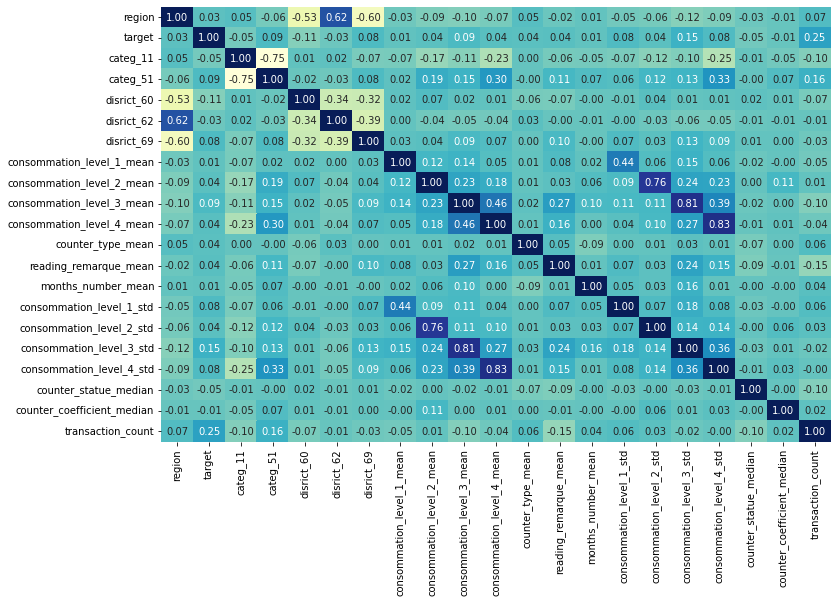

In [77]:
plt.figure(figsize=(12,8))
sns.heatmap(data=train_data.corr(),annot=True,cmap='YlGnBu',fmt=".2f",cbar=False)
plt.show()

In [108]:
##devide train to X_train and y_train
X_train=train_data.drop(['target','client_id','disrict_60','disrict_69','disrict_62','region','months_number_mean','counter_coefficient_median'
,'counter_type_mean','categ_11','categ_51'],axis=1)
y_train=train_data['target']

In [109]:
from collections import Counter
from imblearn.under_sampling import NearMiss
### we sould balance the data because we have much 0 than 1
undersample = NearMiss(version=1, n_neighbors=3)
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.3,random_state=123)
print("the tarin data shape before under_sampling: ", Counter(y_train))
### standrized the data
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)
X_ros,y_ros=undersample.fit_resample(X_train,y_train)
print("the tarin data shape after under_sampling: ", Counter(y_ros))

the tarin data shape before under_sampling:  Counter({0.0: 88919, 1.0: 5219})
the tarin data shape after under_sampling:  Counter({0.0: 5219, 1.0: 5219})


In [57]:
### define the plot function
def plot_val_curve(train_scores, val_scores, param_range, plt_title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(14,6))
    
    plt.title(plt_title)
    plt.xlabel("$C-Regularization parameter$")
    plt.ylabel("Accuracy")
    
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    plt.semilogx(param_range, val_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    
    plt.fill_between(param_range, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

def plot_learning_curve(X,y,clf_estimator, cv_estimator, scorer, xlabel=''):
    train_x_axis, train_scores, test_scores =learning_curve(estimator=clf_estimator,
                                                           X=X,
                                                           y=y,
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=cv_estimator,
                                                           scoring=scorer,
                                                           exploit_incremental_learning=False,
                                                           n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    

def plot_confusion_matrix(cm, class_names, title_text='Confusion Matrix', normalize=False):
    plt.figure(figsize=(10,5))
    acc = cm.diagonal().sum()/cm.sum()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names,
               annot_kws={"size":15})
    plt.title(title_text+' Accuracy = {:.4f}'.format(acc), fontsize=20)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual Class', fontsize=16)
    plt.tick_params(labelsize=14)

In [110]:
#use cross-validation strategy to select the best model
cross=StratifiedShuffleSplit(n_splits=10,random_state=763476)

##Training Model

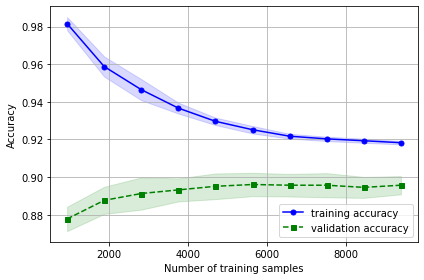

In [111]:
XGB1=xgb(max_depth=5, learning_rate=0.01, n_estimators=1000, verbosity=1, silent=None, objective='binary:logistic', 
           booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0.1,
           reg_lambda=0.1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)
plot_learning_curve(X_ros, y_ros, XGB1, cross,'accuracy',xlabel='Number of training samples')

Cross-validation fold:  1
Cross-validation fold:  2
Cross-validation fold:  3
Cross-validation fold:  4
Cross-validation fold:  5
Cross-validation fold:  6
Cross-validation fold:  7
Cross-validation fold:  8
Cross-validation fold:  9
Cross-validation fold:  10

CV accuracy: 0.896 +/- 0.005

CV Recall: 0.853 +/- 0.012

CV F1_Score: 0.891 +/- 0.005

CV LogLoss: 3.603 +/- 0.167

CV AUPRC: 0.968 +/- 0.003


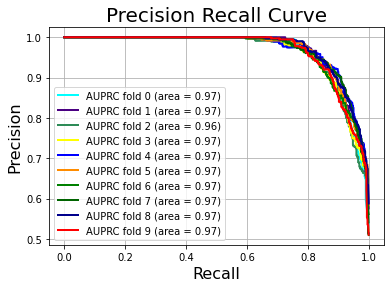

In [117]:
clf_LR_metrics = list()

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange',
                'green', 'darkgreen','darkblue', 'red', 'magenta'])
lw = 2

i = 0

for (train_idx, val_idx), color in zip(cross.split(X_ros, y_ros), colors):
    X_train, y_train = X_ros[train_idx], y_ros[train_idx]
    X_val, y_val = X_ros[val_idx], y_ros[val_idx]
    n_classes = np.unique(y_train) #Get total classes 
    
    #Define and fit a logistic regression classifier
    #clf_LR = LogisticRegression(penalty='l2', C=0.01, solver='liblinear',
                              # random_state=178926, n_jobs=-1, max_iter=1000)
    XGB1.fit(X_train,y=y_train)
    
    #Predict class label and probability for the validation data set
    y_pred = XGB1.predict(X_val)
    y_prob = XGB1.predict_proba(X_val)
    
    #Compute classification metrics
    acc = mt.accuracy_score(y_val, y_pred)
    recall = mt.recall_score(y_val, y_pred)
    f1 = mt.f1_score(y_val, y_pred)
    logloss = mt.log_loss(y_val, y_pred)
    
    #Compute precision, recall and AUPRC for different levels of thresholds
    precisions, recalls, thresholds = mt.precision_recall_curve(y_val.ravel(), y_prob[:, 1].ravel(), pos_label=1)
    prc_auc = mt.average_precision_score(y_val, y_prob[:,1], average='weighted')
    plt.plot(recalls, precisions, lw=lw, color=color,
             label='AUPRC fold %d (area = %0.2f)' % (i, prc_auc))
    
    i +=1 #Counter for validation fold
    print("Cross-validation fold: ",i)
    
    clf_LR_metrics.append([acc, f1, recall, logloss, prc_auc])


#Summary of classification performance
clf_LR_metrics = pd.DataFrame(clf_LR_metrics, columns=['Accuracy','F1_Score', 'Recall', 'LogLoss','AUPRC'])

plt.legend(loc='best')
plt.grid()
plt.title('Precision Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Accuracy), np.std(clf_LR_metrics.Accuracy)))
print('\nCV Recall: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Recall), np.std(clf_LR_metrics.Recall)))
print('\nCV F1_Score: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.F1_Score), np.std(clf_LR_metrics.F1_Score)))
print('\nCV LogLoss: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.LogLoss), np.std(clf_LR_metrics.LogLoss)))
print('\nCV AUPRC: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.AUPRC), np.std(clf_LR_metrics.AUPRC)))

We conclude from the training and the data cleaning that the vaiables that we should are 
'*consommation_level_mean*', 
'*consommation_level_std*', 
'*reading_remarque*',
 '*counter_statue*' 
and '*transaction_count*'

###Test the Model

Confusion matrix, without normalization


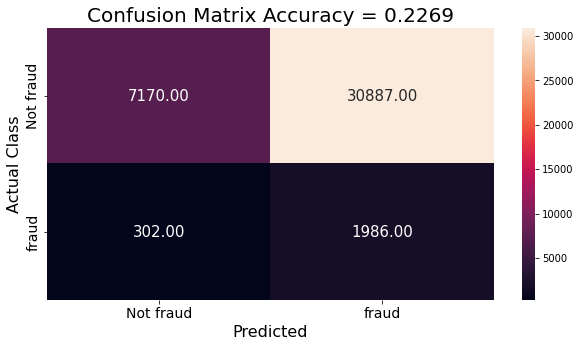

In [120]:
y_pred = XGB1.predict(X_test)
y_prob = XGB1.predict_proba(X_test)
class_names = ['Not fraud', 'fraud']
cm = mt.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)